# <font color='gren'>**Cálculo Numérico - Atividade 2**

## **Alunos:**
* Gabriel Dezejácomo Maruschi - 14571525
* Vitor Alexandre Garcia Vaz - 14611432
* Vitor Pardini Saconi -14611800

## **Imports Necessários**

In [35]:
import numpy as np
from numpy import random

import scipy
from scipy import linalg
from scipy.sparse import diags, linalg

import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

import time

import random

import pandas as pd

## **Funções auxiliares**

**Função para plotar as curvas de nível constante de temperatura**

In [36]:

def PlotaMembrane(N1,N2,L1,L2,W):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(W)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    im = ax.contourf(X, Y, Z, 20)
    im2 = ax.contour(X, Y, Z, 20, linewidths=0.25, colors='k')
    fig.colorbar(im, ax=ax)
    plt.show()
    
def PlotaSurface(N1,N2,L1,L2,W):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(W)
    ax = plt.axes(projection ='3d')
    ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    ax.set_zlim(-1.01, 1.01)
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    

**Montagem das matrizes K e M para placa retangular**

In [37]:
def ij2n (i, j, N):
    return i + j*N

def BuildMatrizesEigen_ret(N1, N2, sigma, rho, e, delta):
    nunk = N1*N2

    # Stiffness matrix K: Build it as a sparse matrix 
    d1 = 4.0*np.ones(nunk)
    d2 = -np.ones(nunk-1)
    d3 = -np.ones(nunk-N1)
    K = (sigma/delta**2)*scipy.sparse.diags([d3, d2, d1, d2, d3], [-N1, -1, 0, 1, N1], format='csr')

    # Force the eigenvalues associated to boundary points 
    # to be a big number as compared to fundamental modes
    big_number = 10000
    Iden = big_number*scipy.sparse.identity(nunk, format='csr')

    # Lados verticais
    for k in range(0,N2):
        Ic = ij2n(0,k,N1) # Left
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(N1-1,k,N1) # Right
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        
    # Lados horizontais
    for k in range(0,N1):
        Ic = ij2n(k,0,N1) # Bottom
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(k,N2-1,N1) # Top
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

    # Mass matrix: Simple case, multiple of identity
    M = rho*e*(scipy.sparse.identity(nunk, format='csr'))
    
    return K, M    

**Montagem das matrizes K e M modificada para placa triangular (triâgulo retângulo)**

* Para isso, a função foi dada de forma que:

    *1-Foram definidos os valores referentes aos lados horizontais e verticais dentro das matrizes K da mesma forma que na função de montagem da membrana retangular.*

    *2-Foi adicionado um laço que , para um ponto i da diagonal do retângulo formado, iguala as colunas e linhas i da matriz K com as colunas e linhas i de uma matriz identidade, com o objetivo de indicar que a movimentação desses pontos - por também formarem uma das bordas da membrana - já é conhecida, pois esses pontos formam o lado correspondente à hipotenusa da membrana triangular.*

    *3-Dentro do laço anterior, para um ponto i superior a diagonal do retângulo até então formado, todos os termos das linhas e colunas i da matriz K são igualados a zero, com o objetivo de mostrar que esses pontos não são abordados nos cáluclos, já que não pertencem à membrana triangular.*

In [38]:
def ij2n (i, j, N):
    return i + j*N

def BuildMatrizesEigen_tri(N, sigma, rho, e, delta):
    nunk = N*N

    # Stiffness matrix K: Build it as a sparse matrix 
    d1 = 4.0*np.ones(nunk)
    d2 = -np.ones(nunk-1)
    d3 = -np.ones(nunk-N)
    K = (sigma/delta**2)*scipy.sparse.diags([d3, d2, d1, d2, d3], [-N, -1, 0, 1, N], format='lil')

    # Force the eigenvalues associated to boundary points 
    # to be a big number as compared to fundamental modes
    big_number = 10000
    Iden = big_number*scipy.sparse.identity(nunk, format='lil')

    # Lado vertical
    for k in range(0,N):
        Ic = ij2n(0,k,N) # Left
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        
    # Lado horizontal
    for k in range(0,N):
        Ic = ij2n(k,0,N) # Bottom
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

    # Lado diagonal
    for i in range(N):
        for j in range(N):
            if((i + j) == N-1): # pontos da hipotenusa
                Ic=ij2n(i,j,N)
                K[Ic,:],K[:,Ic]=Iden[Ic,:],Iden[:,Ic]

            if((i + j) > N-1): # pontos acima da hipotenusa
                Ic=ij2n(i,j,N)
                K[Ic,:],K[:,Ic]=0 , 0

    # Mass matrix: Simple case, multiple of identity
    M = rho*e*(scipy.sparse.identity(nunk, format='lil'))
    
    return K, M

## **a)Exercício 1**

**Plotagem gráfica das 4 primeiras frequências em função do tamanho N da membrana quadrada**

* Para isso, foram cridos e usados 4 vetores - um para cada umas das quatro primeiras frequências - para armazenarem os valores de frequência para cada um dos tamanhos de membrana, os quais foram armazenados em um vetor de tamanhos de N, com o objetivo de possibilitar que todas as atribuições fossem feitas em um laço (for)

* Como estamos tratando do exercício 1, para a montagem das matrizes K e M, em função dos parâmetros definidos no enunciado, foi utilizada a função que monta tais matrizes para uma membrana retangular

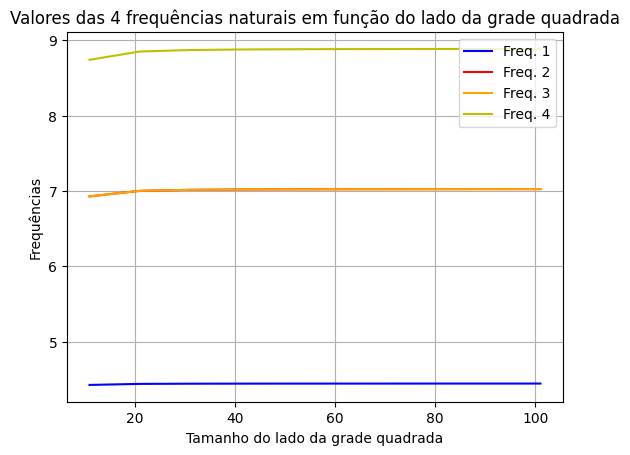

In [39]:

L= 1
valores_N = np.array([11, 21, 31, 41, 51, 61, 81, 101])
freq1 = []
freq2 = []
freq3 = []
freq4 = []

for i in range(valores_N.shape[0]):
    N = valores_N[i]
    delta=L/(N-1)
    K,M=BuildMatrizesEigen_ret(N, N, 1, 1, 1, delta)
    Lam,Q=scipy.sparse.linalg.eigsh(K, k=4, M=M, which='SM')
    omegas=np.sqrt(Lam)
    freq1.append(omegas[0])
    freq2.append(omegas[1])
    freq3.append(omegas[2])
    freq4.append(omegas[3])

#Plot 1
plt.plot(valores_N, freq1, "b", label="Freq. 1")
plt.plot(valores_N, freq2, "r", label="Freq. 2")
plt.plot(valores_N, freq3, "orange", label="Freq. 3")
plt.plot(valores_N, freq4, "y", label="Freq. 4")
plt.legend()
plt.grid()
plt.xlabel("Tamanho do lado da grade quadrada")
plt.ylabel("Frequências")
plt.title("Valores das 4 frequências naturais em função do lado da grade quadrada")
plt.show()

**Exposição da tabela que relaciona cada valor de frequência presente (em um dos quatro vetores) com o tamanho N de membrana para o qual essa frequência foi obtida**

* Para isso, foi criada uma matriz de relações (A) em que a primeira coluna está associada aos valores de tamanho da membrana e as demais colunas estão associadas às 4 primeiras frequências de oscilação escolhidas.

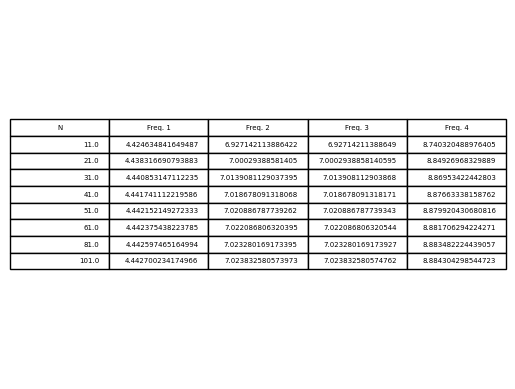

In [40]:
#Tabela
colunas = ["N", "Freq. 1", "Freq. 2", "Freq. 3", "Freq. 4"]
A = np.zeros(shape=(8, 5))
A[:, 0] = valores_N[:]
A[:, 1] = freq1[:]
A[:, 2] = freq2[:]
A[:, 3] = freq3[:]
A[:, 4] = freq4[:]

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df = pd.DataFrame(A, columns=colunas)
ax.table(cellText=df.values, colLabels=df.columns, loc='center', fontsize=24)
plt.show()

**Análise dos resultados obtidos**

* Em primeirom lugar, foi observado que, as frequências - para um vetor de modos naturais - são obtidas em ordem crescente de valores.

* Em segundo lugar, é possível notar que - para essa configuração de membrana - os valores de frequências de oscilação obtidos (da primeira frequência à quarta frequência de oscilação) são proporcionais ao tamanho da membrana.

* Em terceiro lugar, mesmo diante do fato de que os valores de frequência de oscilação obtidos foram proporcionais ao tamanho da membrana contruída, houve um aumento significativo dessas frequências somente entre os valores 11 e 21 de N, enquanto - para valores maiores de tamanho - não houveram grandes aumentos de para nenhuma das 4 frequências de oscição associadas.

* Por fim, para a configuração de membrana quadrada , as segunda e terceira frequências de oscilação apresentaram valores esquivalentes para cada tamanho N de membrana.

## **b)Exercício 2**

**Plotagem gráfica das 4 primeiras frequências em função do tamanho N dos catetos da membrana triangular**

* Para isso, foram cridos e usados 4 vetores - um para cada umas das quatro primeiras frequências - para armazenarem os valores de frequência para cada um dos tamanhos de cateto da membrana, os quais foram armazenados em um vetor de tamanhos N, com o objetivo de possibilitar que todas as atribuições fossem feitas em um laço (for).

* Como estamos tratando do exercício 2, para a montagem das matrizes K e M, em função dos parâmetros definidos no enunciado, foi utilizado a função que monta tais matrizes para uma membrana triangular retangular.

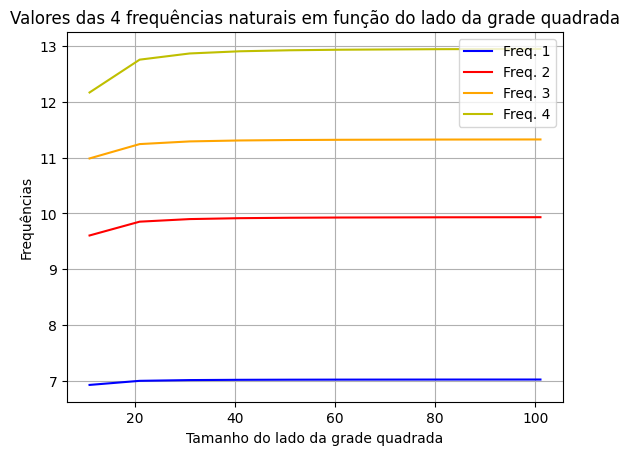

In [41]:

L= 1
valores_N = np.array([11, 21, 31, 41, 51, 61, 81, 101])
freq1 = []
freq2 = []
freq3 = []
freq4 = []

for i in range(valores_N.shape[0]):
    N = valores_N[i]
    delta=L/(N-1)
    K,M=BuildMatrizesEigen_tri(N, 1, 1, 1, delta)
    Lam,Q=scipy.sparse.linalg.eigsh(K, k=4, M=M, which='SM')
    omegas=np.sqrt(Lam)
    freq1.append(omegas[0])
    freq2.append(omegas[1])
    freq3.append(omegas[2])
    freq4.append(omegas[3])

#Plot 1
plt.plot(valores_N, freq1, "b", label="Freq. 1")
plt.plot(valores_N, freq2, "r", label="Freq. 2")
plt.plot(valores_N, freq3, "orange", label="Freq. 3")
plt.plot(valores_N, freq4, "y", label="Freq. 4")
plt.legend()
plt.grid()
plt.xlabel("Tamanho do lado da grade quadrada")
plt.ylabel("Frequências")
plt.title("Valores das 4 frequências naturais em função do lado da grade quadrada")
plt.show()

**Exposição da tabela que relaciona cada valor de frequência presente (em um dos quatro vetores) com o tamanho N - dos catetos da membrana - para o qual essa frequência foi obtida**

* Para isso, foi criada uma matriz de relações (A) em que a primeira coluna está associada aos valores N e as demais colunas estão associadas às 4 primeiras frequências de oscilação escolhidas.

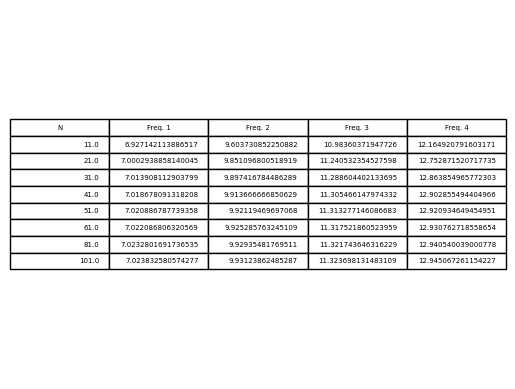

In [42]:
#Tabela
colunas = ["N", "Freq. 1", "Freq. 2", "Freq. 3", "Freq. 4"]
A = np.zeros(shape=(8, 5))
A[:, 0] = valores_N[:]
A[:, 1] = freq1[:]
A[:, 2] = freq2[:]
A[:, 3] = freq3[:]
A[:, 4] = freq4[:]

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df = pd.DataFrame(A, columns=colunas)
ax.table(cellText=df.values, colLabels=df.columns, loc='center', fontsize=24)
plt.show()

**Análise dos resultados obtidos**

* Em primeirom lugar, foi observado que as frequências - para um vetor de modos naturais - também são obtidas em ordem crescente de valores.

* Em segundo lugar, é possível notar que - para essa configuração de membrana - os valores de frequências de oscilação obtidos (da primeira frequência à quarta frequência de oscilação) são proporcionais ao tamanho da membrana.

* Em terceiro lugar, mesmo diante do fato de que os valores de frequência de oscilação obtidos foram proporcionais ao tamanho da membrana contruída, houve um aumento significativo dessas frequências somente entre certos valores de N em cada uma das quatro frequências:

    *-entre os valores 11 e 31 de N para a frequências 1, 2 e 3.*
    
    *-entre os valores 11 e 21 de N para a frequência 4.*
    

* Por fim, para a configuração de membrana triangular , todas as 4 frequências de oscilação apresentaram valores diferentes para um dado tamanho N dos catetos do triângulo retângulo.